# Data Quality Pipeline for Kaggle Datasets

## Objectives of the Notebook
The purpose of this notebook is to apply a standardized pipeline for cleaning and validating data quality for datasets obtained from the Kaggle platform.

## Data Quality (DQ)
Refers to the degree to which data is suitable for its intended use. In other words, data must be accurate, complete, relevant, and reliable in the context in which it is used. Poor data quality can seriously affect the results of analyses, predictive models, and business decisions.

This notebook implements a cleaning and validation pipeline based on the framework proposed in the paper **“The Five Facets of Data Quality Assessment,”** which organizes data quality assessment through:

5 Key Dimensions of DQ:

- Accuracy: Does the data reflect reality?
- Representativeness: Is it representative of the domain it models?
- Completeness: Is data missing or well represented?
- Relevance: Is it useful for the stated objective?

5 Facets for evaluation:

- Data: analysis of digital data and its metadata.
- Source: traceability and quality of the dataset's origin.
- System: technical support, reproducibility, and compliance.
- Task: relevance and adaptation to the specific problem.
- Human: user perception, intention, and needs.


## Applying the Five Facets to the Analysis of Kaggle Datasets

After reviewing the approach proposed in the paper "The Five Facets of Data Quality Assessment" and comparing it with the types of datasets available on Kaggle, We following this adaptation for our case, focused on building a standardized data quality analysis framework:

1. **Data Facet:**
This is the most relevant facet for our use case. We can analyze structure, data types, missing values, schema consistency, and placeholder values. The most challenging part is evaluating accuracy against reference data, since Kaggle datasets typically don't come with ground-truth benchmarks. However, all other aspects can be assessed in an automated and scalable way.

2. **Source Facet:**
We can extract the dataset author's name and check if a source is provided in the dataset description. However, we cannot access version history or transformation lineage through the Kaggle API. Traceability is limited to what is manually documented.

3. **System Facet:**
Kaggle maintains the original state of the dataset, allowing us to assume reproducibility. While we don't have access to low-level storage or file system metadata, this doesn't significantly affect our analysis.

4. **Task Facet:**
If the dataset supports multiple tasks or lacks a clearly defined purpose, this facet becomes harder to apply automatically.

5. **Human Facet:**
This facet depends on knowing the end users, their domain expertise, and the usage context, information we can't access automatically. This would require manual input and should be treated as part of the metadata.

## Selected Dataset

This is a dataset only for experimentation. Our goal is to create a pipeline that would fit any Kaggle dataset. While reviewing different projects and their associated datasets, this one was chosen manually after a search using the Kaggle API, where the best datasets were filtered based on user votes.



## Data Quality Metric Thresholds

There is currently no universally accepted standard for assessing data quality using metrics such as missing values, duplicates, or cardinality. The literature consistently emphasizes that data quality thresholds must be defined based on the specific context, purpose, and domain of use. Papers such as Measuring Data Quality in Information Systems Research, The Challenges of Data Quality and Data Quality Assessment in the Big Data Era, and Increasing Trust in Real-World Evidence Through Evaluation of Observational Data Quality support this view, arguing that rigid, one-size-fits-all thresholds are inadequate. Instead, they advocate for flexible, context-driven frameworks and transparent reporting to ensure that data quality assessments are meaningful and aligned with the goals of the analysis.

## Connect to the Kaggle API and Download the File

In [ ]:
pip install kaggle

In [ ]:
import os
import re
import zipfile
import json
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")

In [ ]:
os.environ['KAGGLE_USERNAME'] = "abnerasteteh"
os.environ['KAGGLE_KEY'] = "5dec29fba975d4119a37855b3653d27d"

# Authentication
api = KaggleApi()
api.authenticate()


#rabieelkharoua/students-performance-dataset
#manjeetsingh/retaildataset

# Dataset to download
dataset_name = 'manjeetsingh/retaildataset'
# Destination folder
download_path = './datasets'
# Download (saved as .zip)
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/manjeetsingh/retaildataset


# ANALIZAR DATASET

## Traceability of Origin and Processing

###Facet: Source
Dimensions covered: Accuracy, Completeness, Reputability

In [ ]:
# Get all reliability information
def comprehensive_dataset_evaluation(dataset_name):
    owner_slug, dataset_slug = dataset_name.split('/')
    ref = f"{owner_slug}/{dataset_slug}"

    # 1. Basic dataset information
    results = api.dataset_list(search=dataset_slug, user=owner_slug)
    dataset_info = None

    for ds in results:
        if ds.ref == ref:
            dataset_info = {
                "dataset_name": ds.title,
                "subtitle": getattr(ds, "subtitle", ""),
                "description": getattr(ds, "description", ""),
                "license": getattr(ds, "license_name", "Unknown"),
                "author": ds.creator_name,
                "kaggle_id": ref,
                "kaggle_url": f"https://www.kaggle.com/datasets/{ref}",
                "total_downloads": ds.download_count,
                "votes": getattr(ds, 'vote_count', 0),
                "is_private": ds.is_private,
                "is_featured": ds.is_featured,
                "usability_rating": getattr(ds, "usabilityRating", None),
                "download_date": datetime.now().date().isoformat(),
                "creation_date": getattr(ds, "creationDate", "Not available"),
                "last_updated": getattr(ds, "lastUpdated", "Not available")
            }
            break

    if not dataset_info:
        raise ValueError(f"Dataset {ref} not found")

    # 2. Author information (reputation and activity)
    def get_all_datasets(user):
        page = 1
        all_datasets = []
        while True:
            try:
                datasets = api.dataset_list(user=user, page=page)
                if not datasets:
                    break
                all_datasets.extend(datasets)
                page += 1
            except:
                break
        return all_datasets

    def get_all_kernels(user):
        page = 1
        all_kernels = []
        while True:
            try:
                kernels = api.kernels_list(user=user, page=page)
                if not kernels:
                    break
                all_kernels.extend(kernels)
                page += 1
            except:
                break
        return all_kernels

    def get_user_followers(username):
        try:
            user_info = api.user_read(username)
            followers = getattr(user_info, "followerCount", "Not available")
            following = getattr(user_info, "followingCount", "Not available")
            tier = getattr(user_info, "tier", "Not available")
            return followers, following, tier
        except:
            return "Not available", "Not available", "Not available"

    try:
        author_datasets = get_all_datasets(owner_slug)
        total_datasets = len(author_datasets)
        author_notebooks = get_all_kernels(owner_slug)
        total_notebooks = len(author_notebooks)
        followers, following, tier = get_user_followers(owner_slug)

        total_downloads = sum(getattr(ds, 'download_count', 0) for ds in author_datasets)
        total_votes = sum(getattr(ds, 'vote_count', 0) for ds in author_datasets)
        notebook_votes = sum(getattr(nb, 'voteCount', 0) for nb in author_notebooks)

        author_stats = {
            "total_datasets": total_datasets,
            "total_notebooks": total_notebooks,
            "total_dataset_downloads": total_downloads,
            "total_dataset_votes": total_votes,
            "total_notebook_votes": notebook_votes,
            "follower_count": followers,
            "following_count": following,
            "author_tier": tier,
            "avg_downloads_per_dataset": round(total_downloads / total_datasets, 2) if total_datasets > 0 else 0,
            "avg_votes_per_dataset": round(total_votes / total_datasets, 2) if total_datasets > 0 else 0
        }

    except Exception as e:
        print(f"Could not retrieve author statistics: {e}")
        author_stats = {"error": "Author information not available"}

    # 3. Notebooks using this dataset
    try:
        notebooks = api.kernels_list(dataset=ref, page_size=100)
        all_notebooks = notebooks.copy()

        for page in range(2, 6):
            try:
                more_notebooks = api.kernels_list(dataset=ref, page=page, page_size=100)
                if not more_notebooks:
                    break
                all_notebooks.extend(more_notebooks)
            except:
                break

        unique_notebooks = []
        seen_refs = set()
        for nb in all_notebooks:
            if nb.ref not in seen_refs:
                unique_notebooks.append(nb)
                seen_refs.add(nb.ref)

        sorted_notebooks = sorted(unique_notebooks, key=lambda x: getattr(x, 'voteCount', 0), reverse=True)
        total_notebooks_using = len(unique_notebooks)

    except Exception as e:
        print(f"Could not retrieve notebooks: {e}")
        total_notebooks_using = 0

    # 4. Dataset versions (traceability)
    try:
        versions = api.dataset_list_versions(ref)
        version_info = {
            "total_versions": len(versions),
            "current_version": versions[0].versionNumber if versions else 1,
            "version_history": []
        }

        for version in versions[:5]:
            version_info["version_history"].append({
                "version": version.versionNumber,
                "creation_date": getattr(version, "creationDate", "Not available"),
                "status": getattr(version, "status", "Not available")
            })
    except Exception as e:
        print(f"Could not retrieve version information: {e}")
        version_info = {"error": "Version information not available"}

    # 5. Build the reliability assessment with corrected structure
    reliability_assessment = {
        "1_author_info": {
            "author": dataset_info["author"],
            "statistics": author_stats,
            "assessment": "✓ Available" if "error" not in author_stats else "✗ Not available"
        },
        "2_publication_date": {
            "creation_date": dataset_info["creation_date"],
            "last_updated": dataset_info["last_updated"],
            "assessment": "✓ Temporal information available" if dataset_info["creation_date"] != "Not available" else "⚠ Temporal information not available"
        },
        "3_license": {
            "license": dataset_info["license"],
            "assessment": "⚠ Unknown license" if dataset_info["license"] == "Unknown" else f"✓ License: {dataset_info['license']}"
        },
        "4_external_source": {
            "description": dataset_info["description"],
            "assessment": "⚠ No detailed description" if not dataset_info["description"] else "✓ Description available"
        },
        "5_traceability": {
            "versions": version_info,
            "assessment": f"✓ {version_info.get('total_versions', 0)} versions available" if "error" not in version_info else "⚠ No version information"
        },
        "6_description": {
            "title": dataset_info["dataset_name"],
            "subtitle": dataset_info["subtitle"],
            "description": dataset_info["description"],
            "assessment": "✓ Clear title and subtitle" if dataset_info["subtitle"] else "⚠ Limited description"
        },
        "7_community_feedback": {
            "votes": dataset_info.get("votes", 0),
            "downloads": dataset_info.get("total_downloads", 0),
            "featured": dataset_info.get("is_featured", False),
            "total_notebooks": total_notebooks_using,
            "assessment": f"✓ {dataset_info.get('votes', 0)} votes, {dataset_info.get('total_downloads', 0)} downloads"
        }
    }

    return {
        "dataset_info": dataset_info,
        "reliability_assessment": reliability_assessment
    }

# Function to display reliability report
def print_reliability_report(evaluation):
    """
    Updated function to display reliability report with correct structure
    """
    print("=" * 80)
    print("DATASET RELIABILITY ASSESSMENT REPORT")
    print("=" * 80)

    dataset_info = evaluation["dataset_info"]
    assessment = evaluation["reliability_assessment"]

    print(f"\nDataset: {dataset_info['dataset_name']}")
    print(f"Author: {dataset_info['author']}")
    print(f"Kaggle URL: {dataset_info['kaggle_url']}")
    print(f"Downloads: {dataset_info['total_downloads']:,}")
    print(f"Votes: {dataset_info['votes']}")
    print(f"License: {dataset_info['license']}")

    for key, value in assessment.items():
        element = key.split("_", 1)[1].replace("_", " ").title()
        print(f"\n{key.split('_')[0]}. {element}")
        print("-" * 50)
        print(f"Assessment: {value['assessment']}")

        if "author" in key:
            print(f"• Author name: {value['author']}")
            if "error" not in value["statistics"]:
                stats = value["statistics"]
                print(f"• Author tier: {stats.get('author_tier', 'N/A')}")
                print(f"• Published datasets: {stats.get('total_datasets', 0)}")
                print(f"• Published notebooks: {stats.get('total_notebooks', 0)}")
                print(f"• Total dataset downloads: {stats.get('total_dataset_downloads', 0):,}")
                print(f"• Total dataset votes: {stats.get('total_dataset_votes', 0):,}")
                print(f"• Followers: {stats.get('follower_count', 'N/A')}")
                print(f"• Avg downloads per dataset: {stats.get('avg_downloads_per_dataset', 0)}")

        elif "publication" in key:
            print(f"• Creation date: {value['creation_date']}")
            print(f"• Last updated: {value['last_updated']}")

        elif "community" in key:
            print(f"• Votes: {value['votes']}")
            print(f"• Downloads: {value['downloads']:,}")
            print(f"• Featured: {'Yes' if value['featured'] else 'No'}")
            print(f"• Notebooks using dataset: {value['total_notebooks']}")

        elif "description" in key:
            print(f"• Title: {value['title']}")
            if value['subtitle']:
                print(f"• Subtitle: {value['subtitle']}")
            if value['description']:
                print(f"• Description: {value['description'][:200]}{'...' if len(value['description']) > 200 else ''}")

        elif "license" in key:
            print(f"• License: {value['license']}")

        elif "external" in key:
            if value['description']:
                print(f"• Description available: Yes")
                print(f"• Description preview: {value['description'][:100]}{'...' if len(value['description']) > 100 else ''}")
            else:
                print(f"• Description available: No")

        elif "traceability" in key:
            if "error" not in value["versions"]:
                versions = value["versions"]
                print(f"• Total versions: {versions.get('total_versions', 0)}")
                print(f"• Current version: {versions.get('current_version', 1)}")
            else:
                print("• Version information: Not available")

# Execute complete evaluation
try:
    full_evaluation = comprehensive_dataset_evaluation(dataset_name)
    print_reliability_report(full_evaluation)

    # Save complete report
    with open('./dataset_reliability_report.json', 'w', encoding='utf-8') as f:
        json.dump(full_evaluation, f, indent=2, ensure_ascii=False, default=str)

    print(f"\n\nComplete report saved to: ./dataset_reliability_report.json")

except Exception as e:
    print(f"Error during evaluation: {e}")

Could not retrieve version information: 'KaggleApi' object has no attribute 'dataset_list_versions'
DATASET RELIABILITY ASSESSMENT REPORT

1. Author Info
--------------------------------------------------
Assessment: ✓ Available
• Author name: Manjeet Singh
• Tier: Not available
• Published datasets: 1
• Published notebooks: 37
• Total dataset downloads: 97,875
• Total dataset votes: 1,082
• Total notebook votes: 0
• Followers: Not available
• Following: Not available
• Avg downloads per dataset: 97875.0
• Avg votes per dataset: 1082.0

2. Publication Date
--------------------------------------------------
Assessment: ✓ Temporal information available
• Creation date: Not available
• Last updated: Not available
• Downloaded on: 2025-08-16

3. License
--------------------------------------------------
Assessment: ✓ License: CC0: Public Domain

4. External Source
--------------------------------------------------
Assessment: ⚠ No detailed description

5. Notebook Usage
-------------------

## Data Loading and Initial Exploration

### Facets: Data

Covered dimensions: Accuracy, Completeness, Representativity


In [ ]:
# Function to convert numpy data types to native Python types
def convert_numpy_types(obj):
    if hasattr(obj, 'item'):  # If object has 'item', it's likely a numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # If object has 'tolist', it's likely a numpy array
        return obj.tolist()
    elif isinstance(obj, dict):   # If it's a dictionary
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):   # If it's a list
        return [convert_numpy_types(item) for item in obj]
    return obj  # If none of the above, return the object as-is

# Function to extract metadata from a CSV file
def extract_csv_metadata(file_path):
    file_path = Path(file_path)  # Ensure file_path is a Path object
    metadata = {
        'filename': file_path.name,
        'file_path': str(file_path),
        'analysis_timestamp': datetime.now().isoformat(),
        'file_exists': file_path.exists(),
        'file_info': {},  # Placeholder for file details (size, creation/modification date)
        'csv_schema': {},  # Placeholder for CSV schema info (columns, types)
        'data_quality': {},  # Placeholder for data quality metrics
        'errors': []
    }

    if not file_path.exists():  # If the file does not exist
        metadata['errors'].append(f"File not found: {file_path}")
        return metadata

    try:
        stat_info = file_path.stat()  # Get file statistics
        metadata['file_info'] = {
            'size_bytes': stat_info.st_size,
            'size_mb': round(stat_info.st_size / (1024*1024), 2),
            'creation_time': datetime.fromtimestamp(stat_info.st_ctime).isoformat(),
            'modification_time': datetime.fromtimestamp(stat_info.st_mtime).isoformat(),
            'extension': file_path.suffix.lower(),
        }

        try:
            # Read first 1000 rows for sampling
            df_sample = pd.read_csv(file_path, nrows=1000)
            # Read entire CSV
            df_full = pd.read_csv(file_path)

            # Store schema information
            metadata['csv_schema'] = {
                'total_rows': len(df_full),
                'total_columns': len(df_full.columns),
                'columns': list(df_full.columns),
                'column_types': df_full.dtypes.astype(str).to_dict(),
                'memory_usage_mb': round(df_full.memory_usage(deep=True).sum() / (1024*1024), 2),
                'shape': df_full.shape
            }

            # Data quality analysis
            metadata['data_quality'] = {
                'null_values_per_column': df_full.isnull().sum().to_dict(),
                'null_percentage_per_column': (df_full.isnull().sum() / len(df_full) * 100).round(2).to_dict(),
                'total_null_values': int(df_full.isnull().sum().sum()),
                'duplicate_rows': int(df_full.duplicated().sum()),
                'unique_values_per_column': df_full.nunique().to_dict(),
                'completeness_score': round((1 - df_full.isnull().sum().sum() / df_full.size) * 100, 2)
            }

            # Sample data for each column
            sample_data = {}
            for col in df_full.columns:
                non_null_values = df_full[col].dropna()
                sample_data[col] = {
                    'first_values': non_null_values.head(3).tolist() if len(non_null_values) > 0 else [],  # First 3 non-null values
                    'unique_count': int(df_full[col].nunique()),
                    'has_nulls': bool(df_full[col].isnull().any())
                }

            metadata['sample_data'] = sample_data

            # Numeric column statistics
            numeric_columns = df_full.select_dtypes(include=['number']).columns
            if len(numeric_columns) > 0:
                numeric_stats = df_full[numeric_columns].describe().to_dict()  # Descriptive stats for numeric columns
                metadata['numeric_statistics'] = convert_numpy_types(numeric_stats)  # Convert numpy types to Python types

            # Categorical column analysis
            categorical_columns = df_full.select_dtypes(include=['object']).columns
            categorical_info = {}
            for col in categorical_columns:
                value_counts = df_full[col].value_counts().head(5)  # Top 5 frequent values
                categorical_info[col] = {
                    'top_5_values': value_counts.to_dict(),  # Top 5 values and counts
                    'unique_count': int(df_full[col].nunique()),
                    'most_frequent': str(value_counts.index[0]) if len(value_counts) > 0 else None
                }

            metadata['categorical_analysis'] = convert_numpy_types(categorical_info)

        except pd.errors.EmptyDataError:
            metadata['errors'].append("CSV file is empty")
        except pd.errors.ParserError as e:
            metadata['errors'].append(f"Error parsing CSV: {str(e)}")
        except Exception as e:
            metadata['errors'].append(f"Error reading CSV: {str(e)}")

    except Exception as e:
        metadata['errors'].append(f"Error accessing file: {str(e)}")

    return metadata  # Return the full metadata dictionary

# Function to analyze multiple CSV files in a directory
def analyze_multiple_csvs(directory_path):
    directory_path = Path(directory_path)  # Ensure directory path is a Path object

    analysis_report = {
        'directory': str(directory_path),
        'analysis_timestamp': datetime.now().isoformat(),
        'csv_files_found': 0,
        'total_directory_size_mb': 0,
        'files_analysis': {},
        'summary': {
            'total_rows': 0,
            'total_columns_unique': set(),
            'common_columns': {},
            'errors': []
        }
    }

    if not directory_path.exists():
        analysis_report['summary']['errors'].append(f"Directory does not exist: {directory_path}")
        return analysis_report

    csv_files = list(directory_path.glob('*.csv'))  # List all CSV files in directory
    analysis_report['csv_files_found'] = len(csv_files)

    all_columns = []

    for csv_file in csv_files:
        print(f"Analyzing: {csv_file.name}")
        file_metadata = extract_csv_metadata(csv_file)  # Extract metadata for each CSV

        analysis_report['files_analysis'][csv_file.name] = file_metadata

        if not file_metadata['errors']:
            file_size_mb = file_metadata['file_info'].get('size_mb', 0)
            analysis_report['total_directory_size_mb'] += file_size_mb

            if 'csv_schema' in file_metadata:
                analysis_report['summary']['total_rows'] += file_metadata['csv_schema'].get('total_rows', 0)
                columns = file_metadata['csv_schema'].get('columns', [])
                all_columns.extend(columns)
                analysis_report['summary']['total_columns_unique'].update(columns)
        else:
            analysis_report['summary']['errors'].extend(file_metadata['errors'])

    if all_columns:
        from collections import Counter
        column_counts = Counter(all_columns)  # Count occurrence of each column name
        analysis_report['summary']['common_columns'] = dict(column_counts.most_common(10))  # Top 10 common columns

    analysis_report['summary']['total_columns_unique'] = list(analysis_report['summary']['total_columns_unique'])

    return analysis_report

# Function to save metadata to a JSON file
def save_metadata_report(metadata, output_path):
    try:
        import json
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        print(f"Report saved at: {output_path}")
    except Exception as e:
        print(f"Error saving report: {e}")

# Function to plot histograms for numeric columns of a CSV file
def plot_histograms(file_data):
    file_path = file_data.get('file_path')
    filename = file_data.get('filename', 'File')

    if not file_path or not Path(file_path).exists():
        print(f"Cannot open {filename} for plotting")
        return

    try:
        df_full = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {filename} for plotting: {e}")
        return

    # Choose preferred plot style if available
    available_styles = plt.style.available
    preferred_styles = ['seaborn', 'ggplot', 'fivethirtyeight', 'bmh']
    selected_style = 'classic'

    for style in preferred_styles:
        if style in available_styles:
            selected_style = style
            break

    plt.style.use(selected_style)

    numeric_columns = df_full.select_dtypes(include=['number']).columns
    n = len(numeric_columns)
    if n == 0:
        print("No numeric columns to plot")
        return

    colors = plt.cm.tab10.colors
    cols = min(4, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(numeric_columns):
        col_data = df_full[col].dropna()
        unique_vals = col_data.unique()
        num_unique = len(unique_vals)
        bins = num_unique if num_unique <= 15 else 'auto'  # Decide bin count

        # Compute statistics
        mean_val = col_data.mean()
        median_val = col_data.median()
        std_val = col_data.std()
        skewness = col_data.skew()
        kurt = col_data.kurtosis()

        # Plot histogram
        axes[i].hist(col_data, bins=bins,
                     edgecolor='white',
                     linewidth=1.2,
                     color=colors[i % len(colors)],
                     alpha=0.8)

        # Add vertical lines for mean and median
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')

        # Set titles and labels
        axes[i].set_title(f"Distribution of {col}", pad=15, fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col, labelpad=10)
        axes[i].set_ylabel('Frequency', labelpad=10)
        axes[i].grid(axis='y', alpha=0.3)

        # Add stats as text box
        stats_text = (f"Mean: {mean_val:.2f}\n"
                     f"Median: {median_val:.2f}\n"
                     f"Std. Dev.: {std_val:.2f}\n"
                     f"Skewness: {skewness:.2f}\n"
                     f"Kurtosis: {kurt:.2f}")

        axes[i].text(0.95, 0.95, stats_text,
                     transform=axes[i].transAxes,
                     ha='right', va='top',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

        if num_unique <= 15:
            axes[i].set_xticks(np.linspace(col_data.min(), col_data.max(), num=min(10, num_unique)))

        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # Remove empty subplots

    fig.suptitle(f"Distribution Analysis - {filename}\n(Style: {selected_style})",
                 y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    print("\n")

# Function to plot boxplots with outliers for numeric columns
def plot_boxplots_with_outliers(file_data):
    file_path = file_data.get('file_path')
    filename = file_data.get('filename', 'File')

    if not file_path or not Path(file_path).exists():
        print(f"Cannot open {filename} for plotting")
        return

    try:
        df_full = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {filename} for plotting: {e}")
        return

    # Choose preferred plot style if available
    available_styles = plt.style.available
    preferred_styles = ['seaborn', 'ggplot', 'fivethirtyeight', 'bmh']
    selected_style = next((s for s in preferred_styles if s in available_styles), 'classic')
    plt.style.use(selected_style)

    numeric_columns = df_full.select_dtypes(include=['number']).columns
    n = len(numeric_columns)
    if n == 0:
        print("No numeric columns to plot")
        return

    colors = plt.cm.tab10.colors
    cols = min(4, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(numeric_columns):
        col_data = df_full[col].dropna()

        # Compute statistics for boxplot
        mean_val = col_data.mean()
        median_val = col_data.median()
        q1 = col_data.quantile(0.25)
        q3 = col_data.quantile(0.75)
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr
        outliers = col_data[(col_data < lower_whisker) | (col_data > upper_whisker)]

        axes[i].boxplot(col_data, patch_artist=True, notch=True,
                        boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6),
                        medianprops=dict(color='red', linewidth=2),
                        flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.6))

        axes[i].set_title(f"Boxplot of {col}", fontsize=12, fontweight='bold')
        axes[i].set_ylabel(col)
        axes[i].grid(axis='y', alpha=0.3)

        # Add outliers count as text
        axes[i].text(0.95, 0.95, f"Outliers: {len(outliers)}",
                     transform=axes[i].transAxes,
                     ha='right', va='top',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused subplots

    fig.suptitle(f"Boxplot Analysis - {filename}\n(Style: {selected_style})",
                 y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    print("\n")


=== CSV Metadata Extractor ===

Analyzing directory: ./datasets
Analyzing: stores data-set.csv
Analyzing: sales data-set.csv
Analyzing: Features data set.csv
CSV files found: 3
Total size: 13.22 MB
Total rows: 429805
Report saved at: ./datasets_analysis.json




















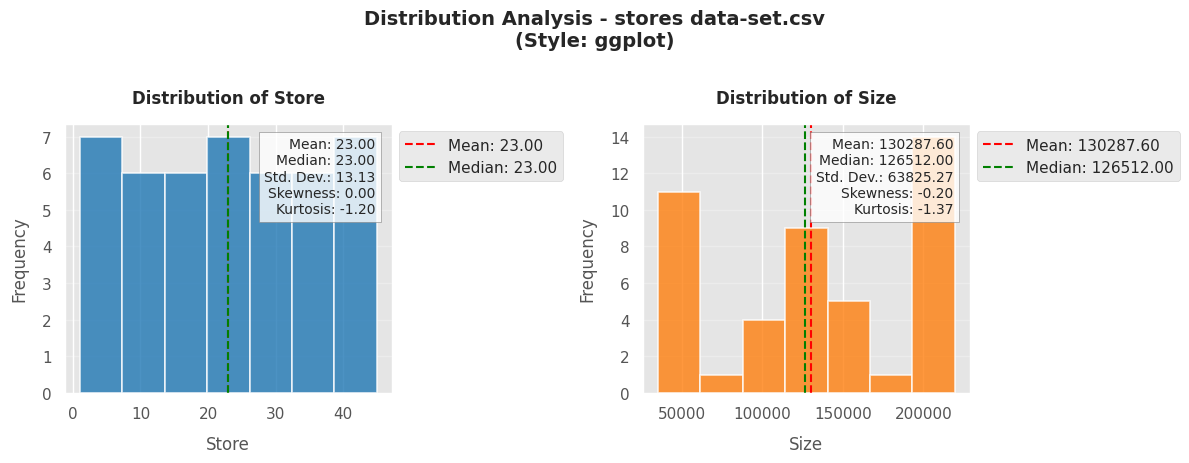

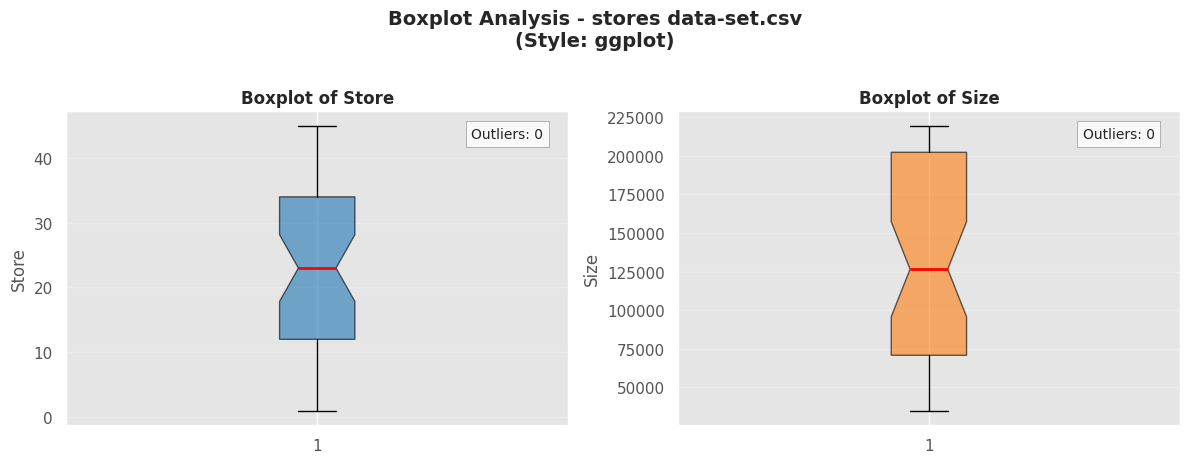

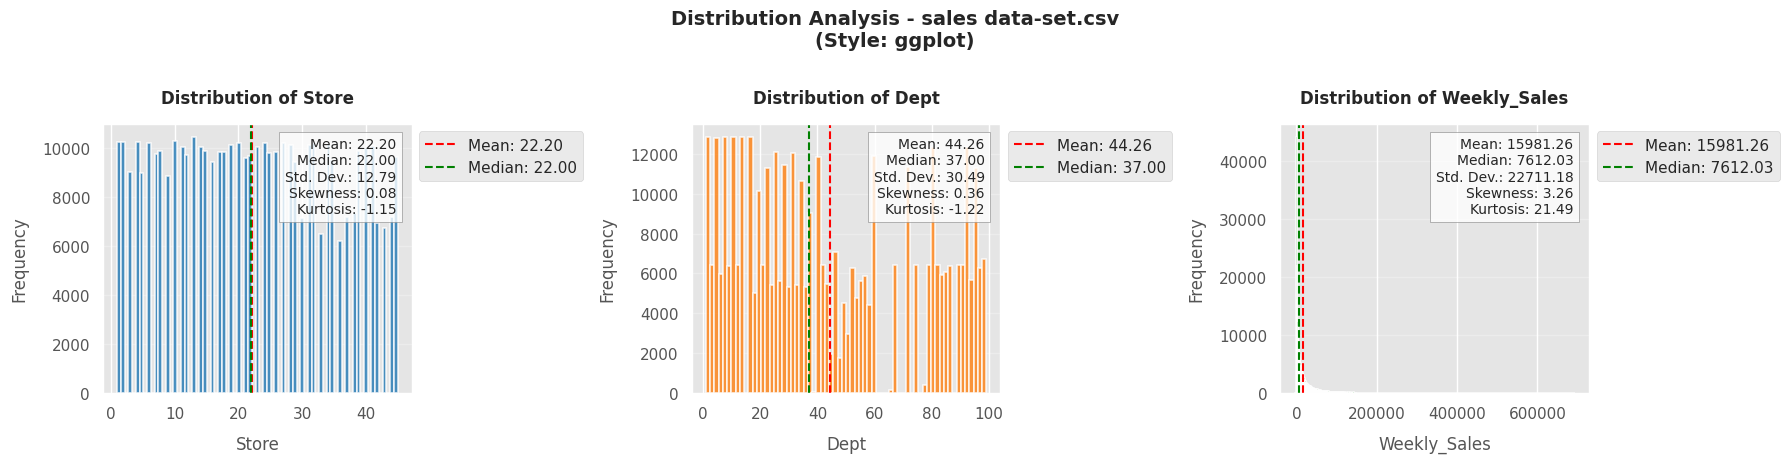

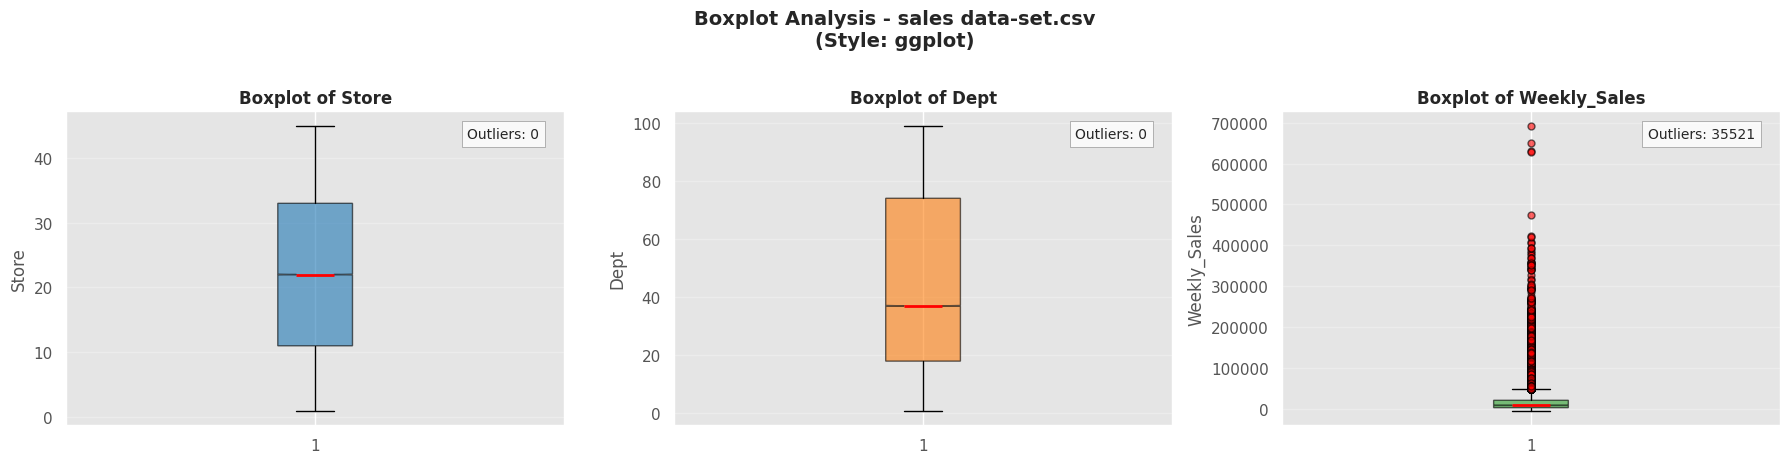

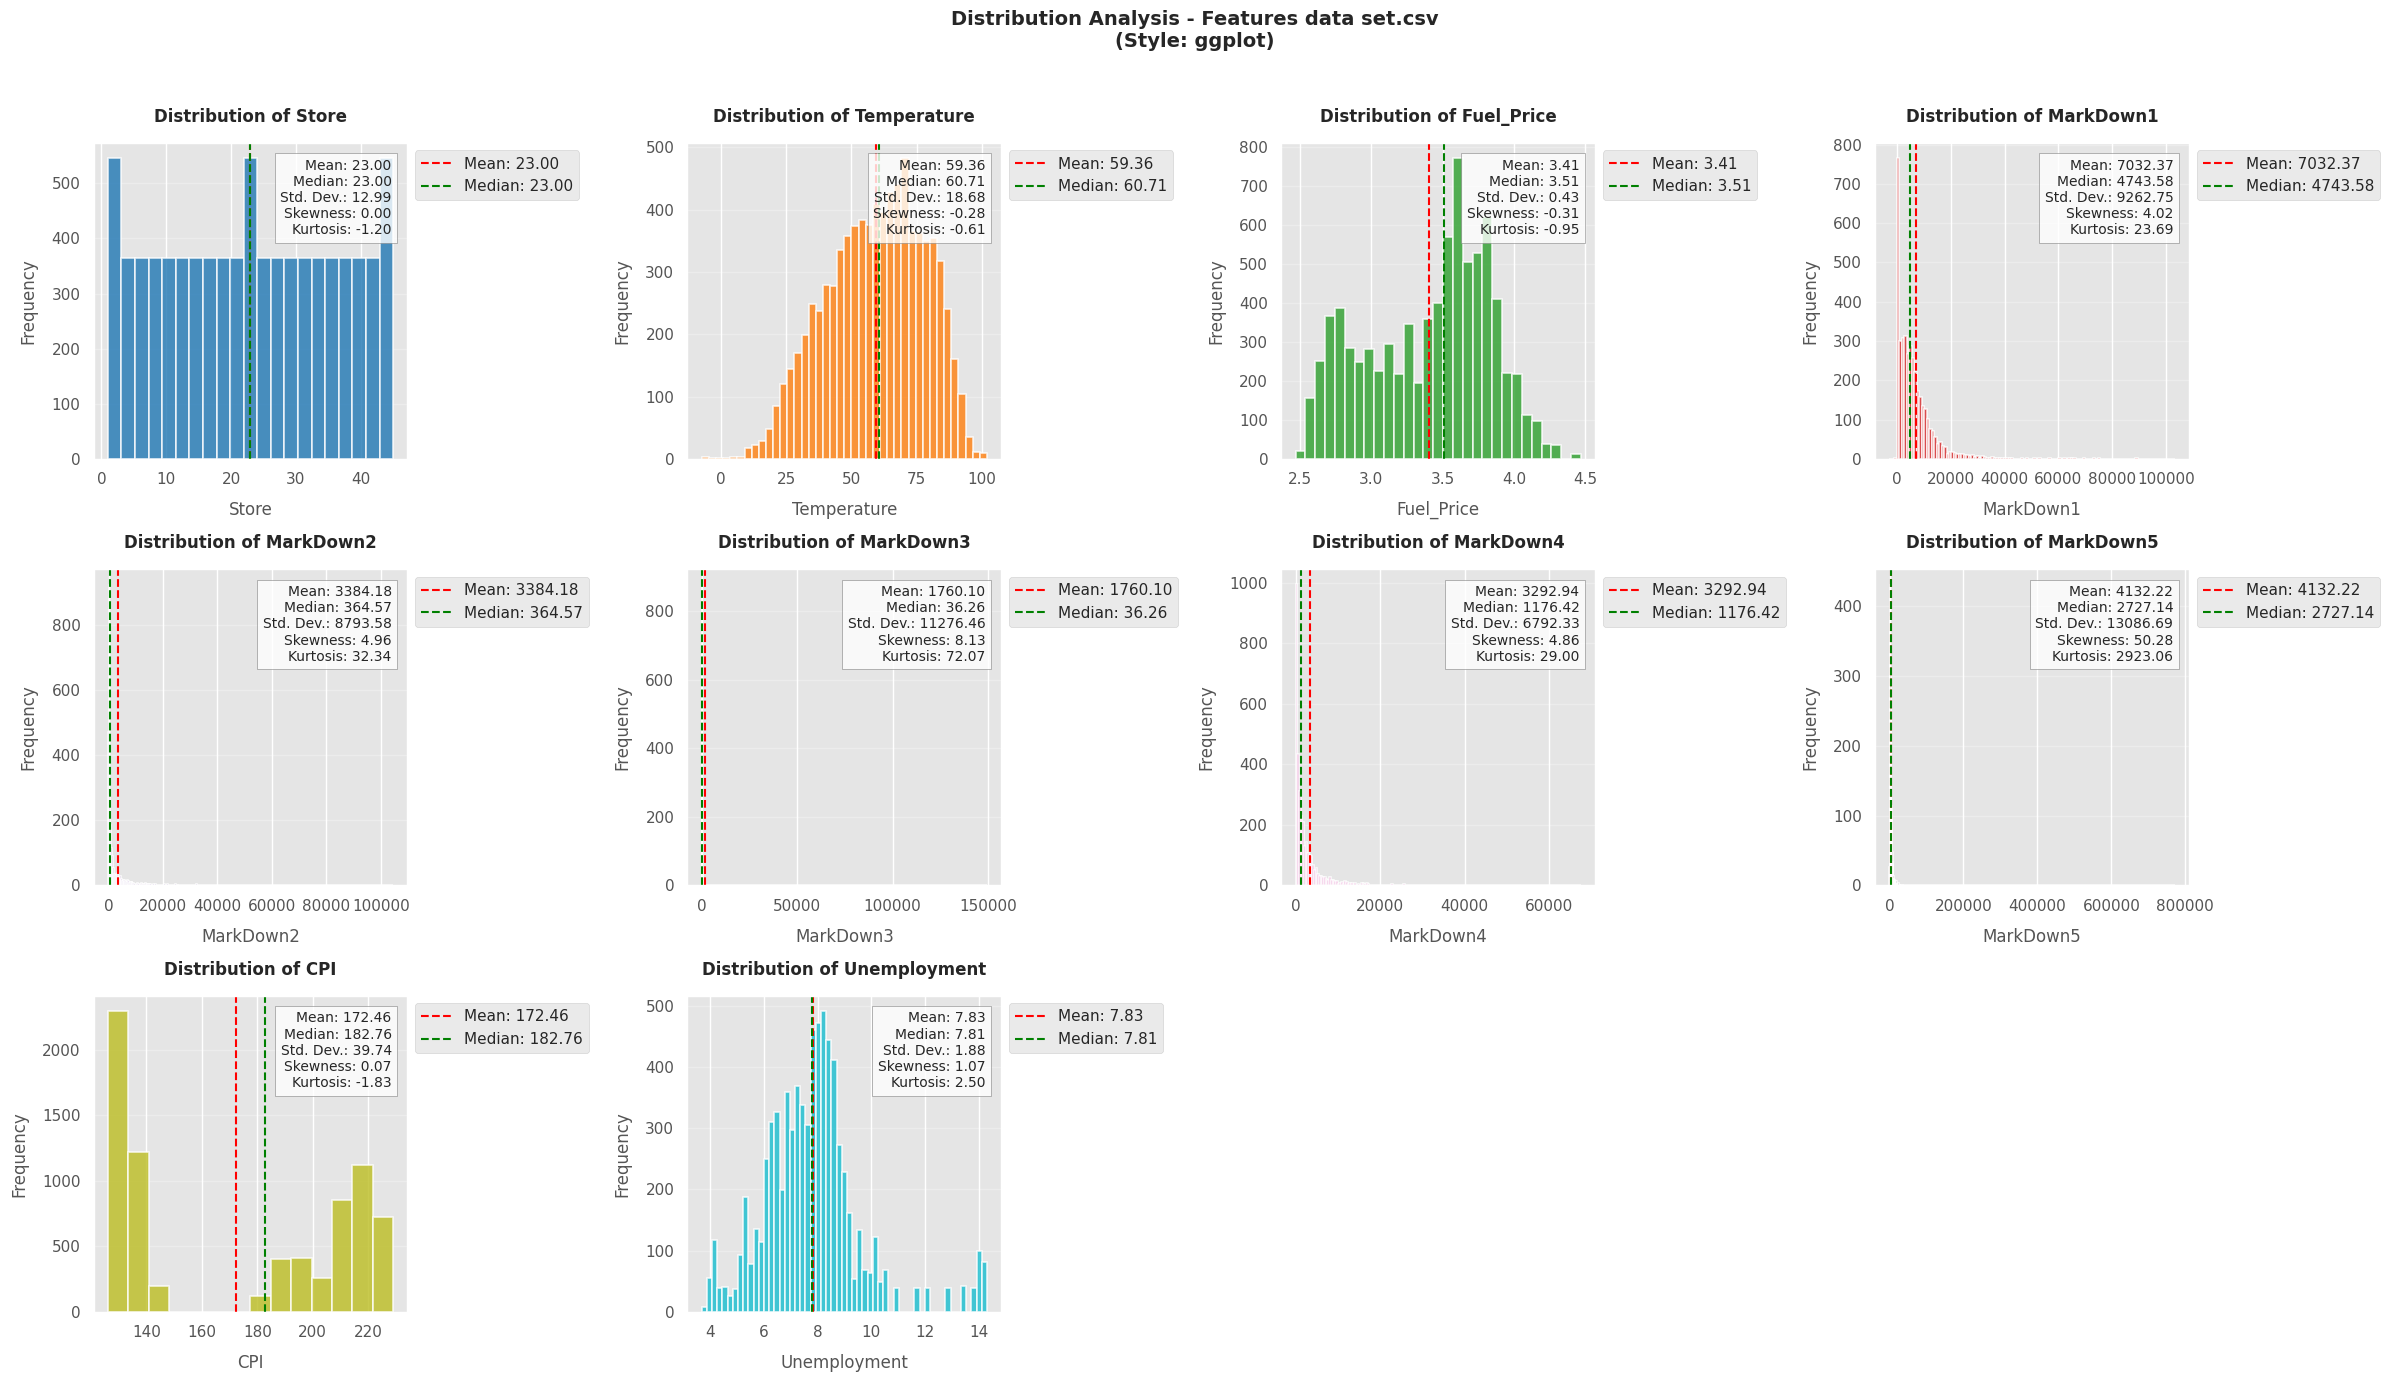

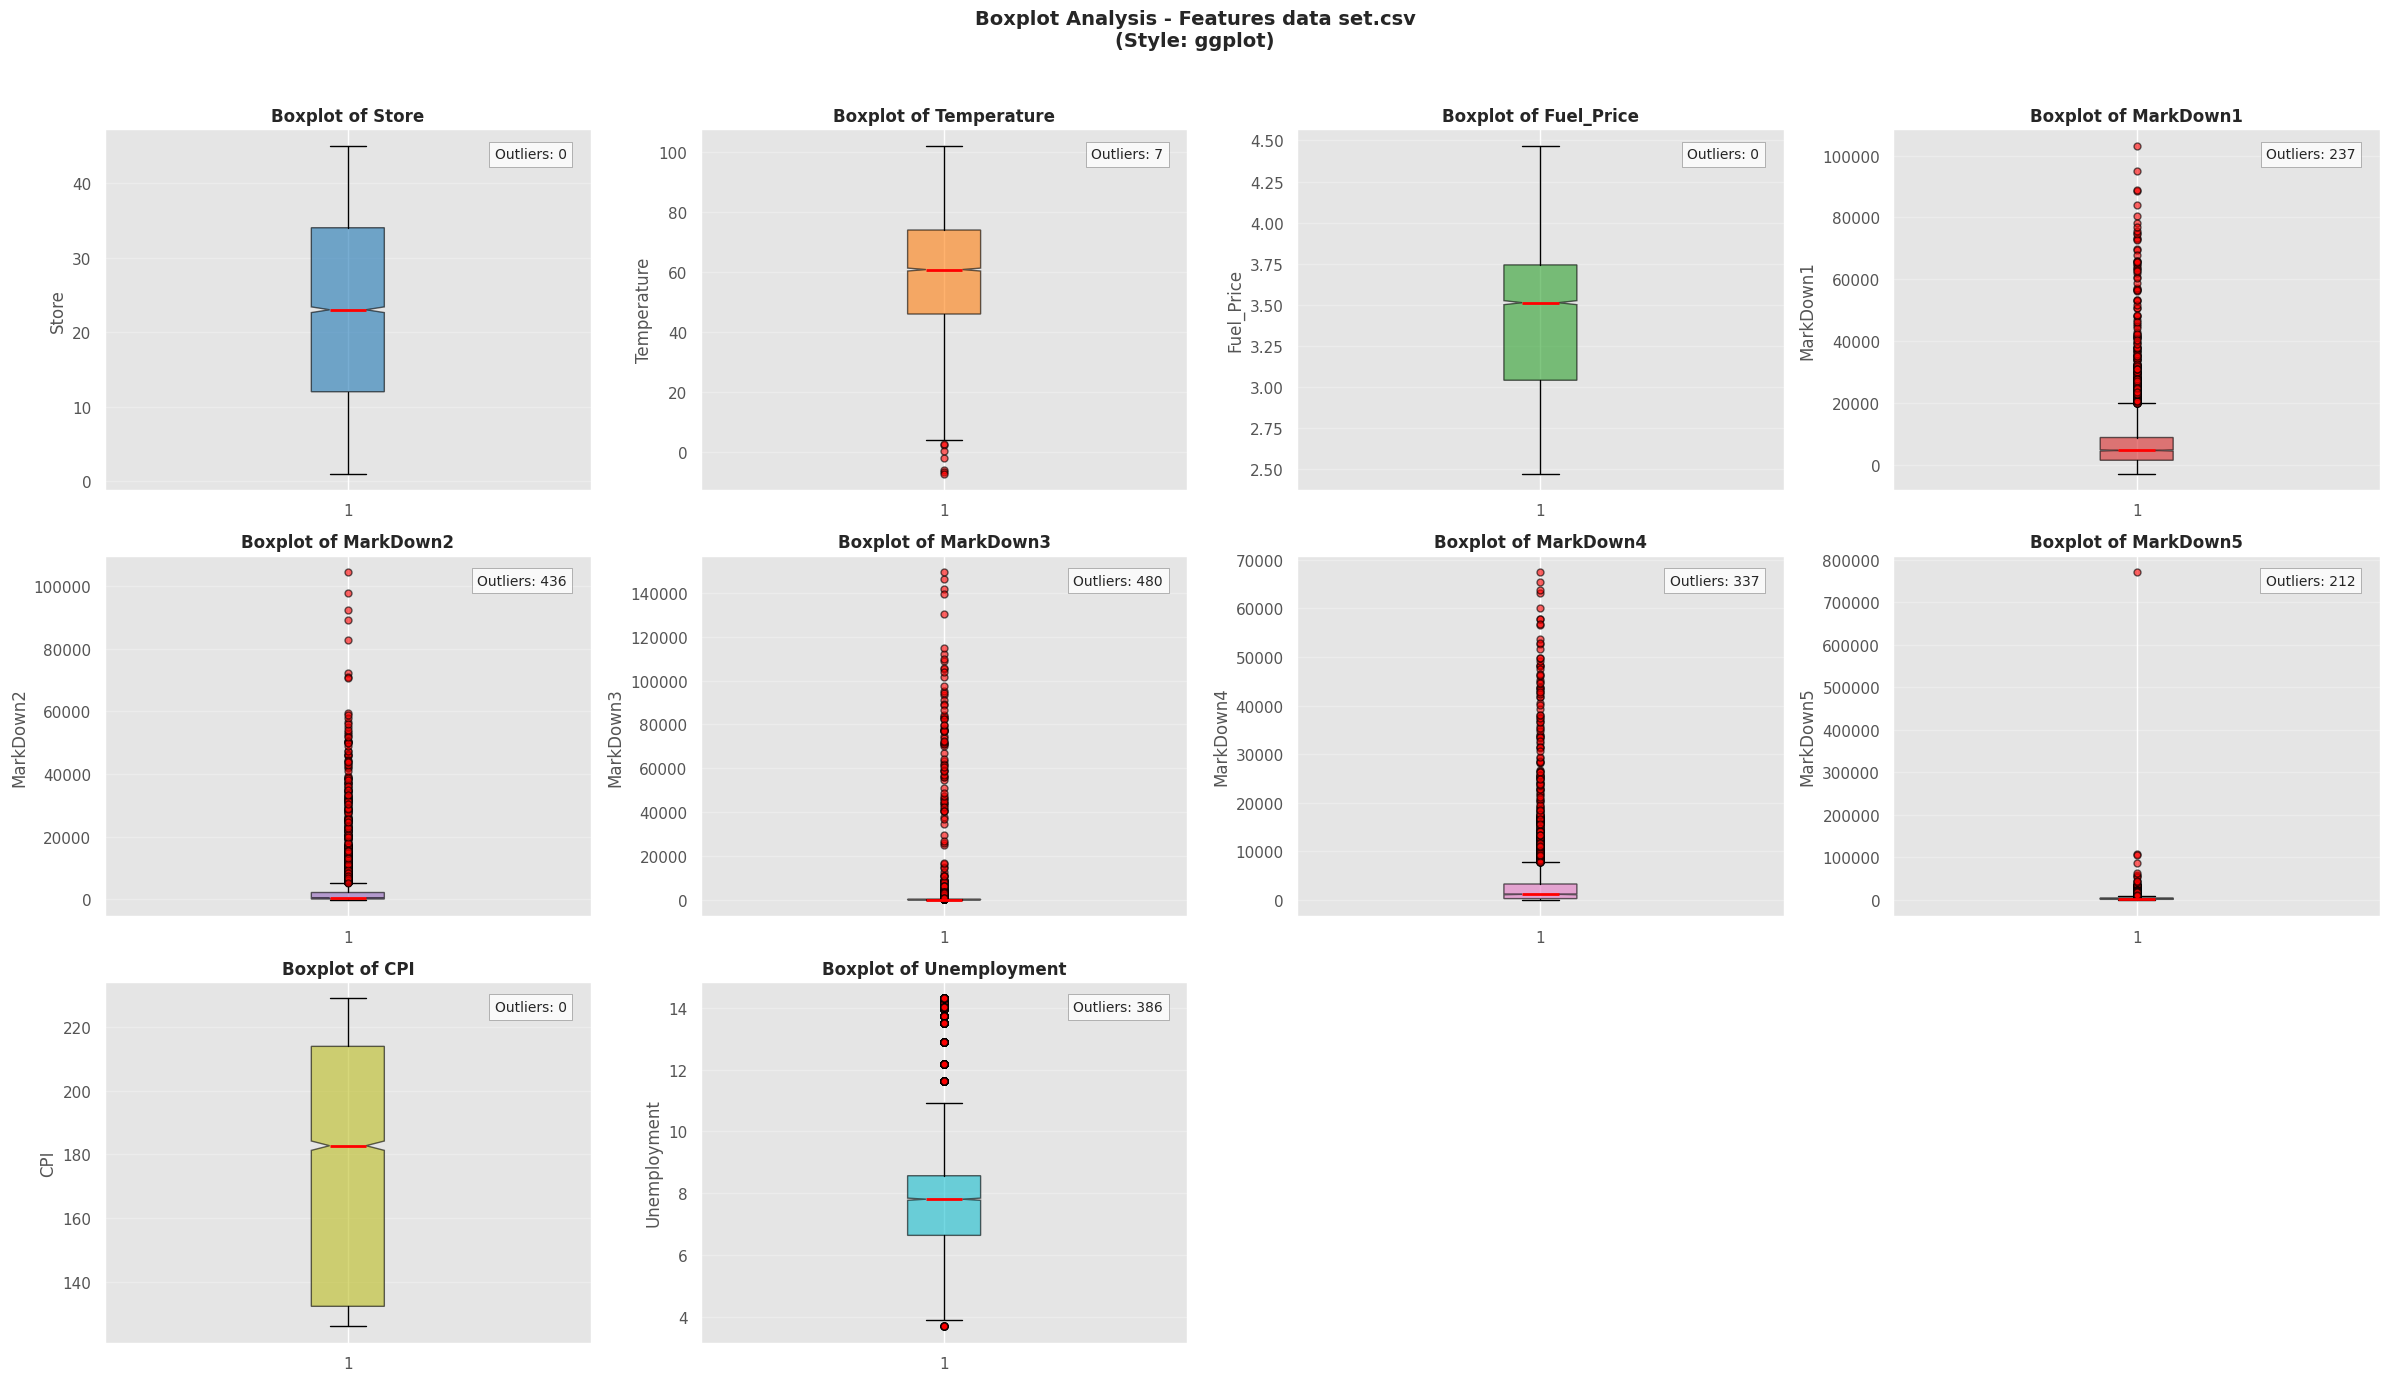

In [ ]:
def main_analysis():
    print("=== CSV Metadata Extractor ===\n")
    directory = "./datasets"

    if os.path.exists(directory):
        print(f"Analyzing directory: {directory}")
        directory_analysis = analyze_multiple_csvs(directory)

        print(f"CSV files found: {directory_analysis['csv_files_found']}")
        print(f"Total size: {directory_analysis['total_directory_size_mb']} MB")
        print(f"Total rows: {directory_analysis['summary']['total_rows']}")

        save_metadata_report(directory_analysis, f"{directory}_analysis.json")

        for filename, file_data in directory_analysis['files_analysis'].items():
            plot_histograms(file_data)
            print("\n")
            plot_boxplots_with_outliers(file_data)
    else:
        print(f"Directory not found: {directory}")


main_analysis()

# Limpizar DATASET

In [ ]:
# Weight configuration
WEIGHTS = {
    "completeness": 0.45,
    "uniqueness": 0.25,
    "outliers": 0.30
}

ALERT_THRESHOLD = 75  # Minimum acceptable score
DATASETS_FOLDER = Path("./datasets")  # Path where the CSV files are located

# Calculates the percentage of non-missing (complete) data in the dataset.
def calculate_completeness(null_percentage_per_column):
    return 100 - np.mean(list(null_percentage_per_column.values()))

#Calculates the percentage of unique rows, penalizing duplicates.
def calculate_uniqueness(total_rows, duplicate_rows):
    return max(0, 100 - (duplicate_rows / total_rows * 100))

# Calculates a score reflecting how free numeric columns are from extreme outliers.
def calculate_outliers(data):
    penalties = []
    for col, stats in data.get("numeric_statistics", {}).items():
        mean = stats.get("mean", 0)
        std = stats.get("std", 0)
        col_min = stats.get("min", mean)
        col_max = stats.get("max", mean)
        if std > 0:
            if col_min < mean - 3 * std or col_max > mean + 3 * std:
                penalties.append(1)
            else:
                penalties.append(0)
    return 100 - (np.mean(penalties) * 100) if penalties else 100

def calculate_global_score(dataset):
    completeness = calculate_completeness(dataset["data_quality"]["null_percentage_per_column"])
    uniqueness = calculate_uniqueness(dataset["csv_schema"]["total_rows"], dataset["data_quality"]["duplicate_rows"])
    outliers = calculate_outliers(dataset)

    global_score = (
        completeness * WEIGHTS["completeness"] +
        uniqueness * WEIGHTS["uniqueness"] +
        outliers * WEIGHTS["outliers"]
    )

    return {
        "completeness": completeness,
        "uniqueness": uniqueness,
        "outliers": outliers,
        "global_score": global_score
    }

# Professional dataset cleaning with categorical removal logic
def clean_dataset(file_path, lower_quantile=0.05, upper_quantile=0.95, max_missing_frac=0.1):
    # Load dataset
    df = pd.read_csv(file_path)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Impute missing numeric values with median using SimpleImputer
    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Handle missing categorical values by dropping rows if missing fraction is small
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        missing_frac = df[col].isna().mean()
        if 0 < missing_frac <= max_missing_frac:
            df = df[df[col].notna()]  # Drop rows with missing values in this column

    # Drop duplicate rows
    df = df.drop_duplicates()

    # Clip numeric values to remove extreme outliers based on quantiles
    for col in numeric_cols:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = np.clip(df[col], lower, upper)

    # Create output directory if it doesn't exist
    output_dir = DATASETS_FOLDER / "cleaned"
    output_dir.mkdir(exist_ok=True)

    # Save cleaned dataset
    output_path = output_dir / f"clean_{Path(file_path).name}"
    df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved at {output_path}")

    # Return path to cleaned CSV
    return output_path


# Generate analysis structure from CSV
def generate_analysis_from_csv(file_path):
    df = pd.read_csv(file_path)
    null_percentage_per_column = df.isnull().mean() * 100
    total_rows = len(df)
    duplicate_rows = total_rows - len(df.drop_duplicates())

    numeric_statistics = {}
    for col in df.select_dtypes(include=[np.number]):
        numeric_statistics[col] = {
            "mean": df[col].mean(),
            "std": df[col].std(),
            "min": df[col].min(),
            "max": df[col].max()
        }

    return {
        "data_quality": {
            "null_percentage_per_column": null_percentage_per_column.to_dict(),
            "duplicate_rows": duplicate_rows
        },
        "csv_schema": {
            "total_rows": total_rows
        },
        "numeric_statistics": numeric_statistics
    }


Dataset: stores data-set.csv
Quality Scores: {'completeness': np.float64(100.0), 'uniqueness': 100.0, 'outliers': np.float64(100.0), 'global_score': np.float64(100.0)}
Dataset meets quality standards.





Dataset: sales data-set.csv
Quality Scores: {'completeness': np.float64(100.0), 'uniqueness': 100.0, 'outliers': np.float64(66.66666666666667), 'global_score': np.float64(90.0)}
Dataset meets quality standards.





Dataset: Features data set.csv
Quality Scores: {'completeness': np.float64(75.54), 'uniqueness': 100.0, 'outliers': np.float64(30.0), 'global_score': np.float64(67.993)}
ALERT: Features data set.csv (67.99) below threshold.
Cleaned dataset saved at datasets/cleaned/clean_Features data set.csv
New analysis after cleaning: {'completeness': np.float64(100.0), 'uniqueness': 100.0, 'outliers': np.float64(70.0), 'global_score': np.float64(91.0)}
Cleaning improved the dataset and it is now above threshold.





New analysis saved at datasets_analysis_clean.json


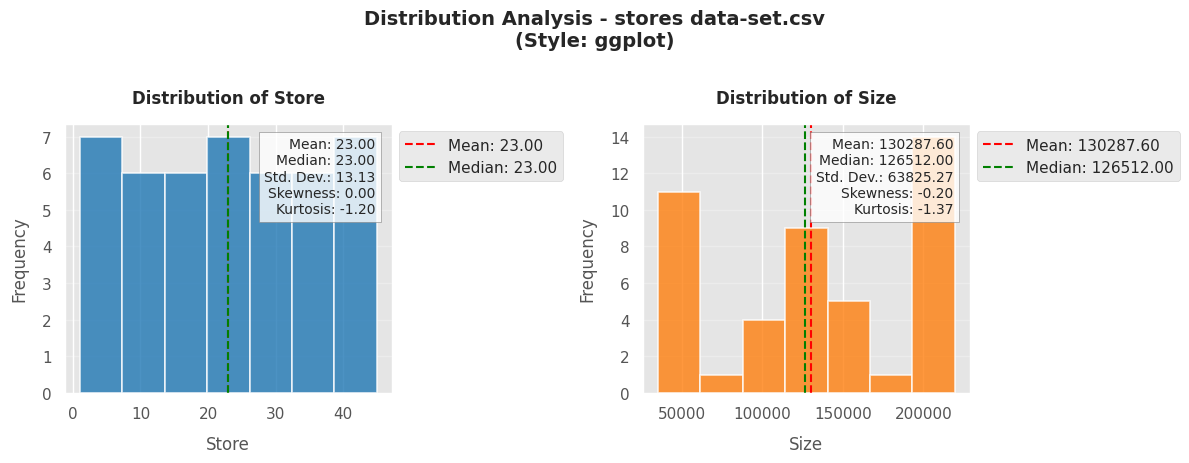

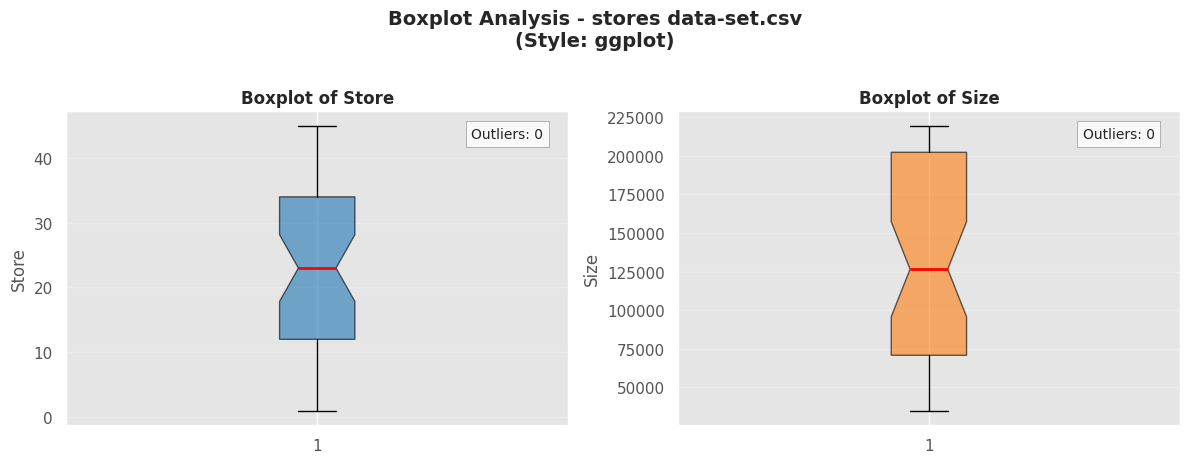

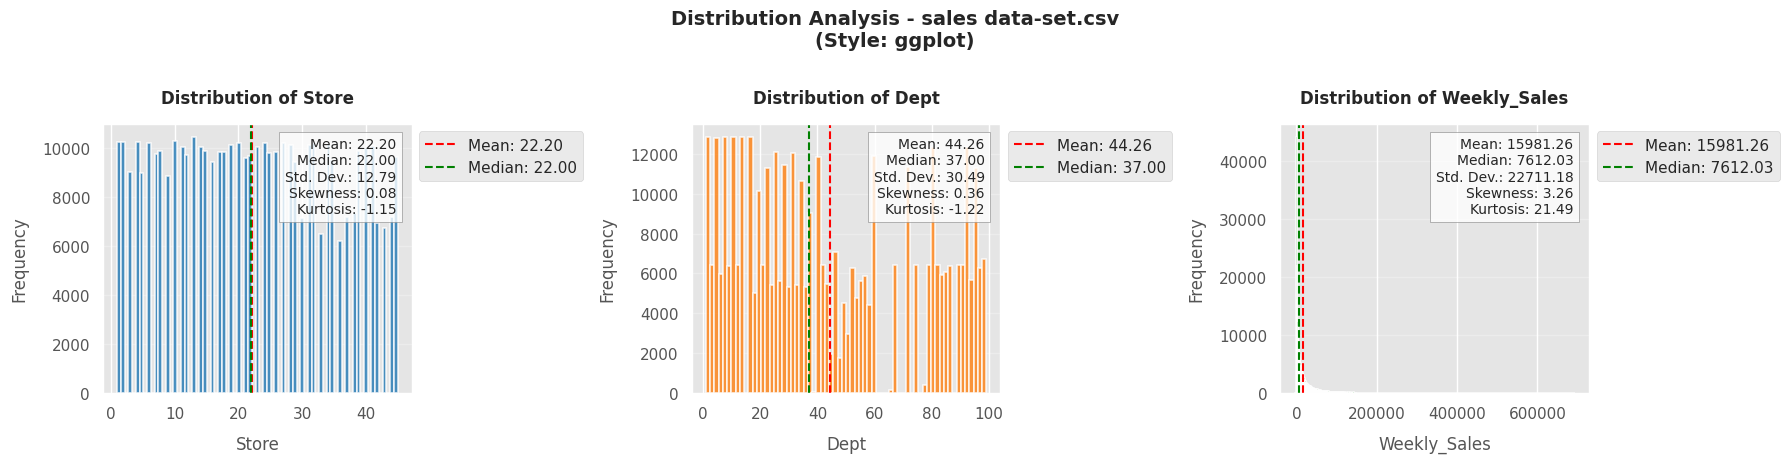

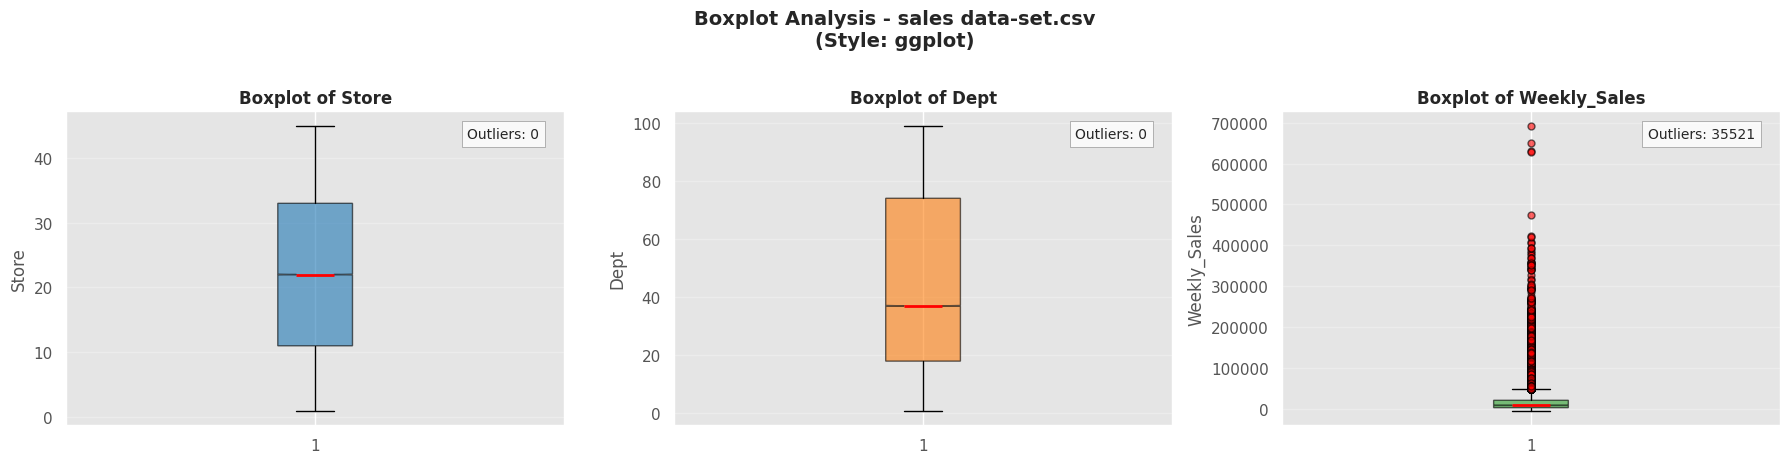

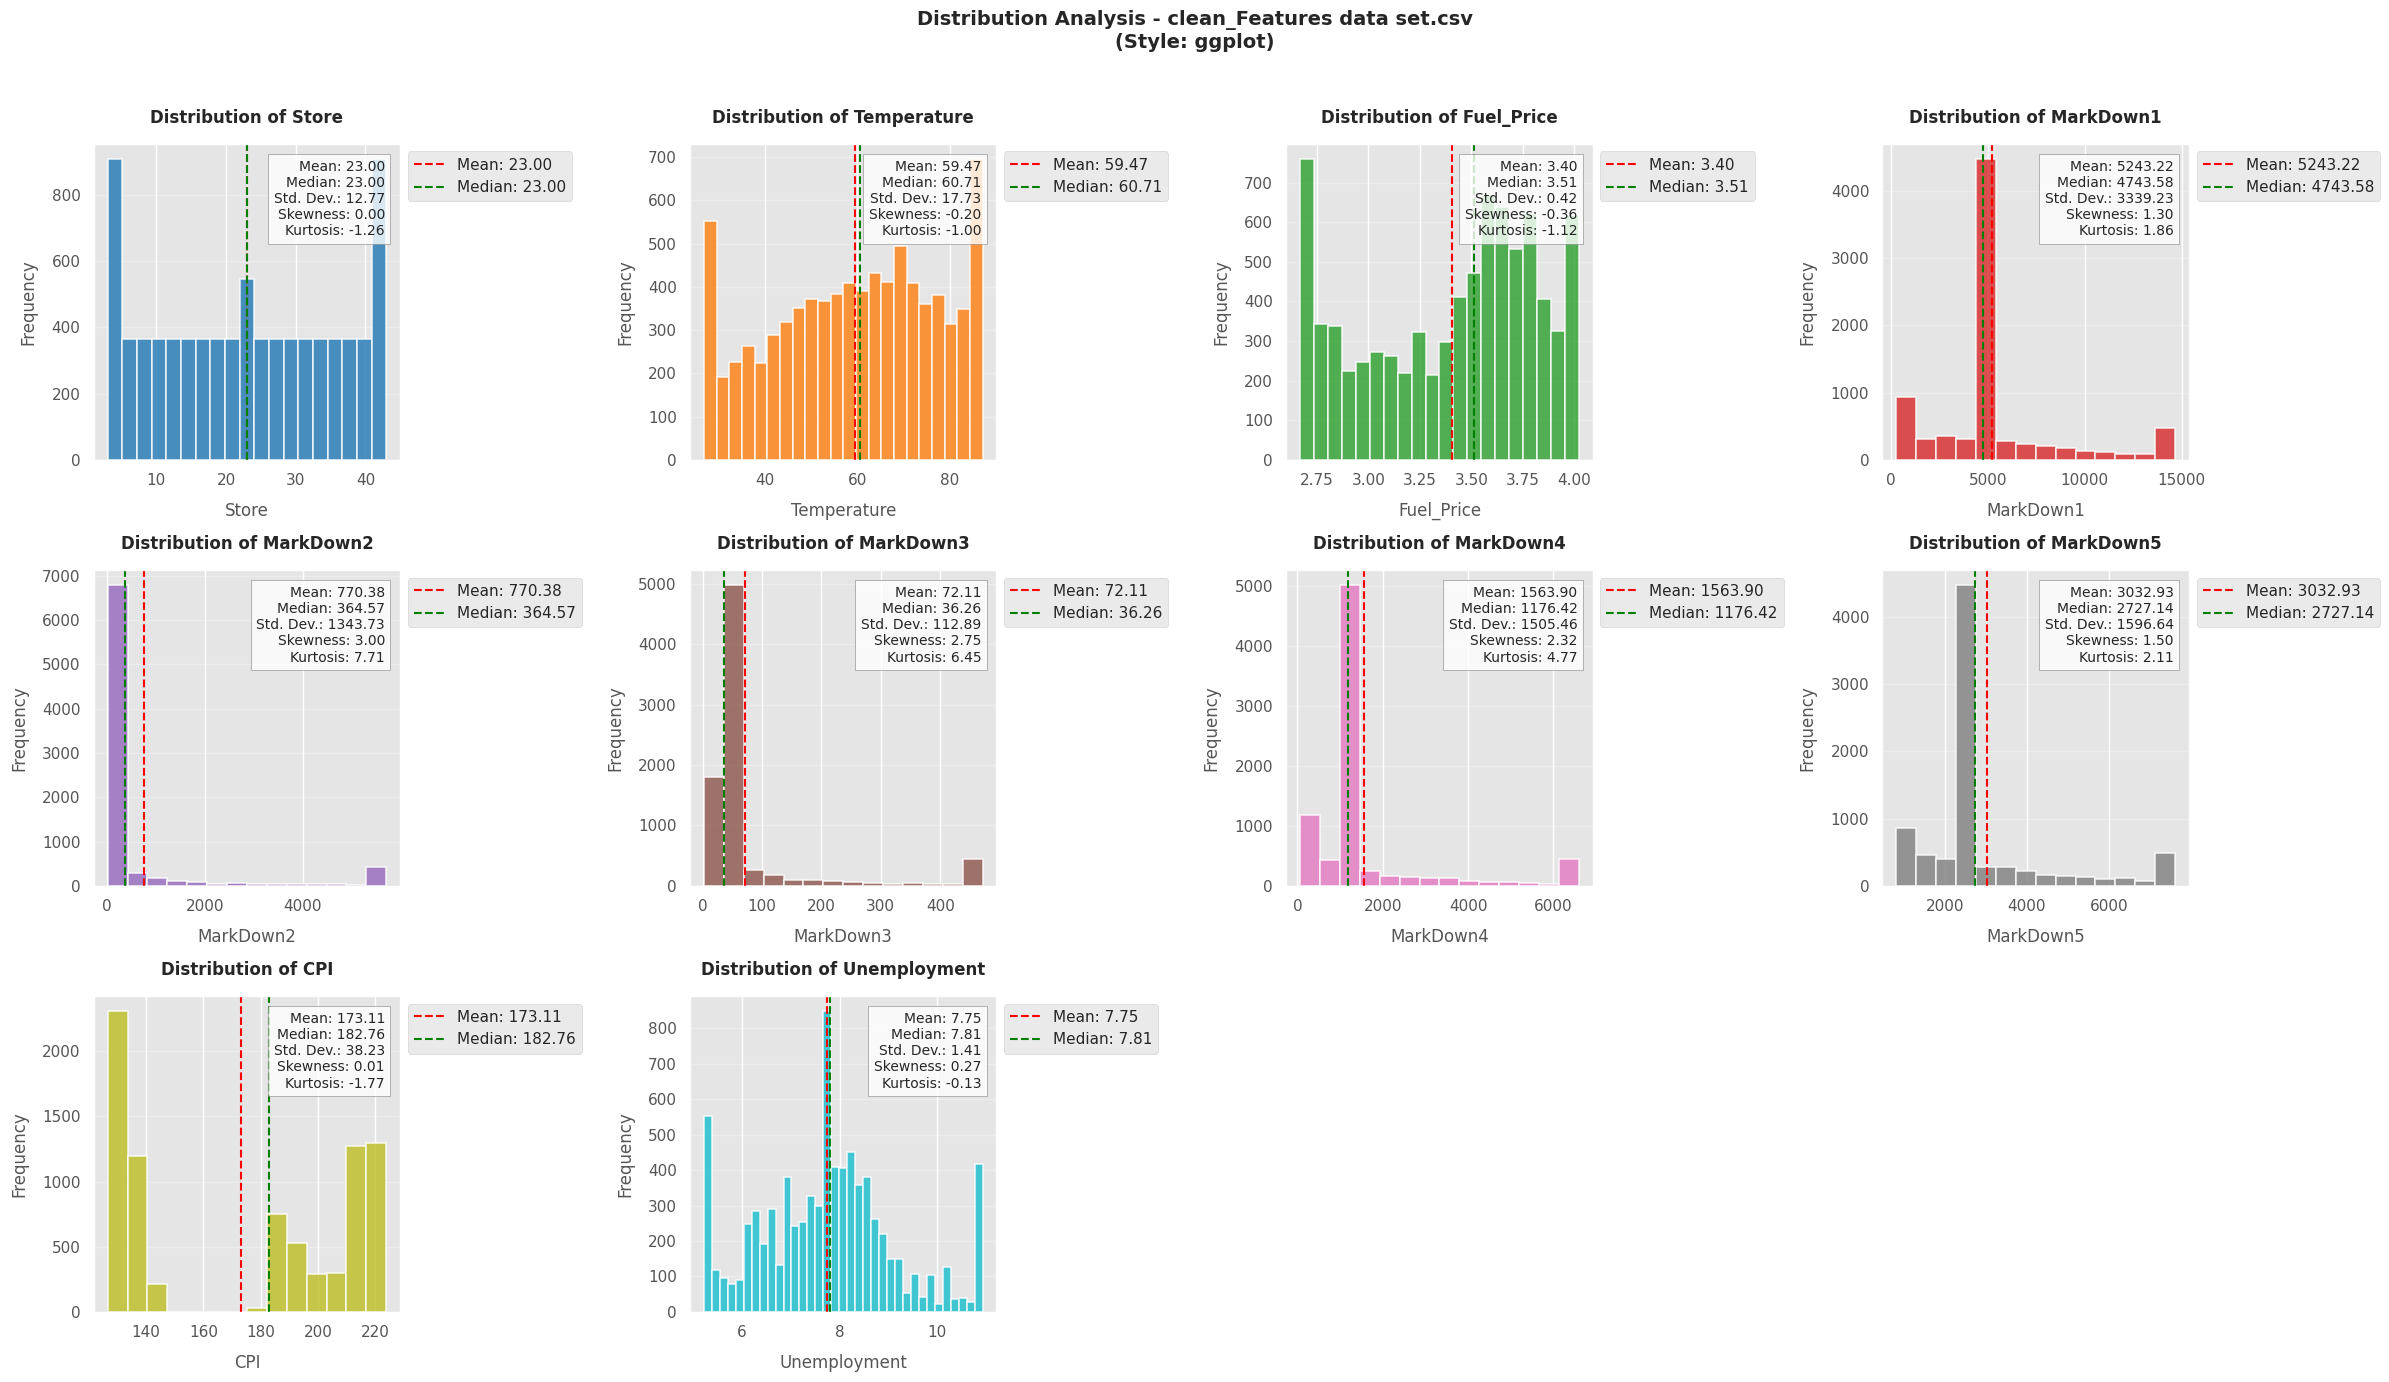

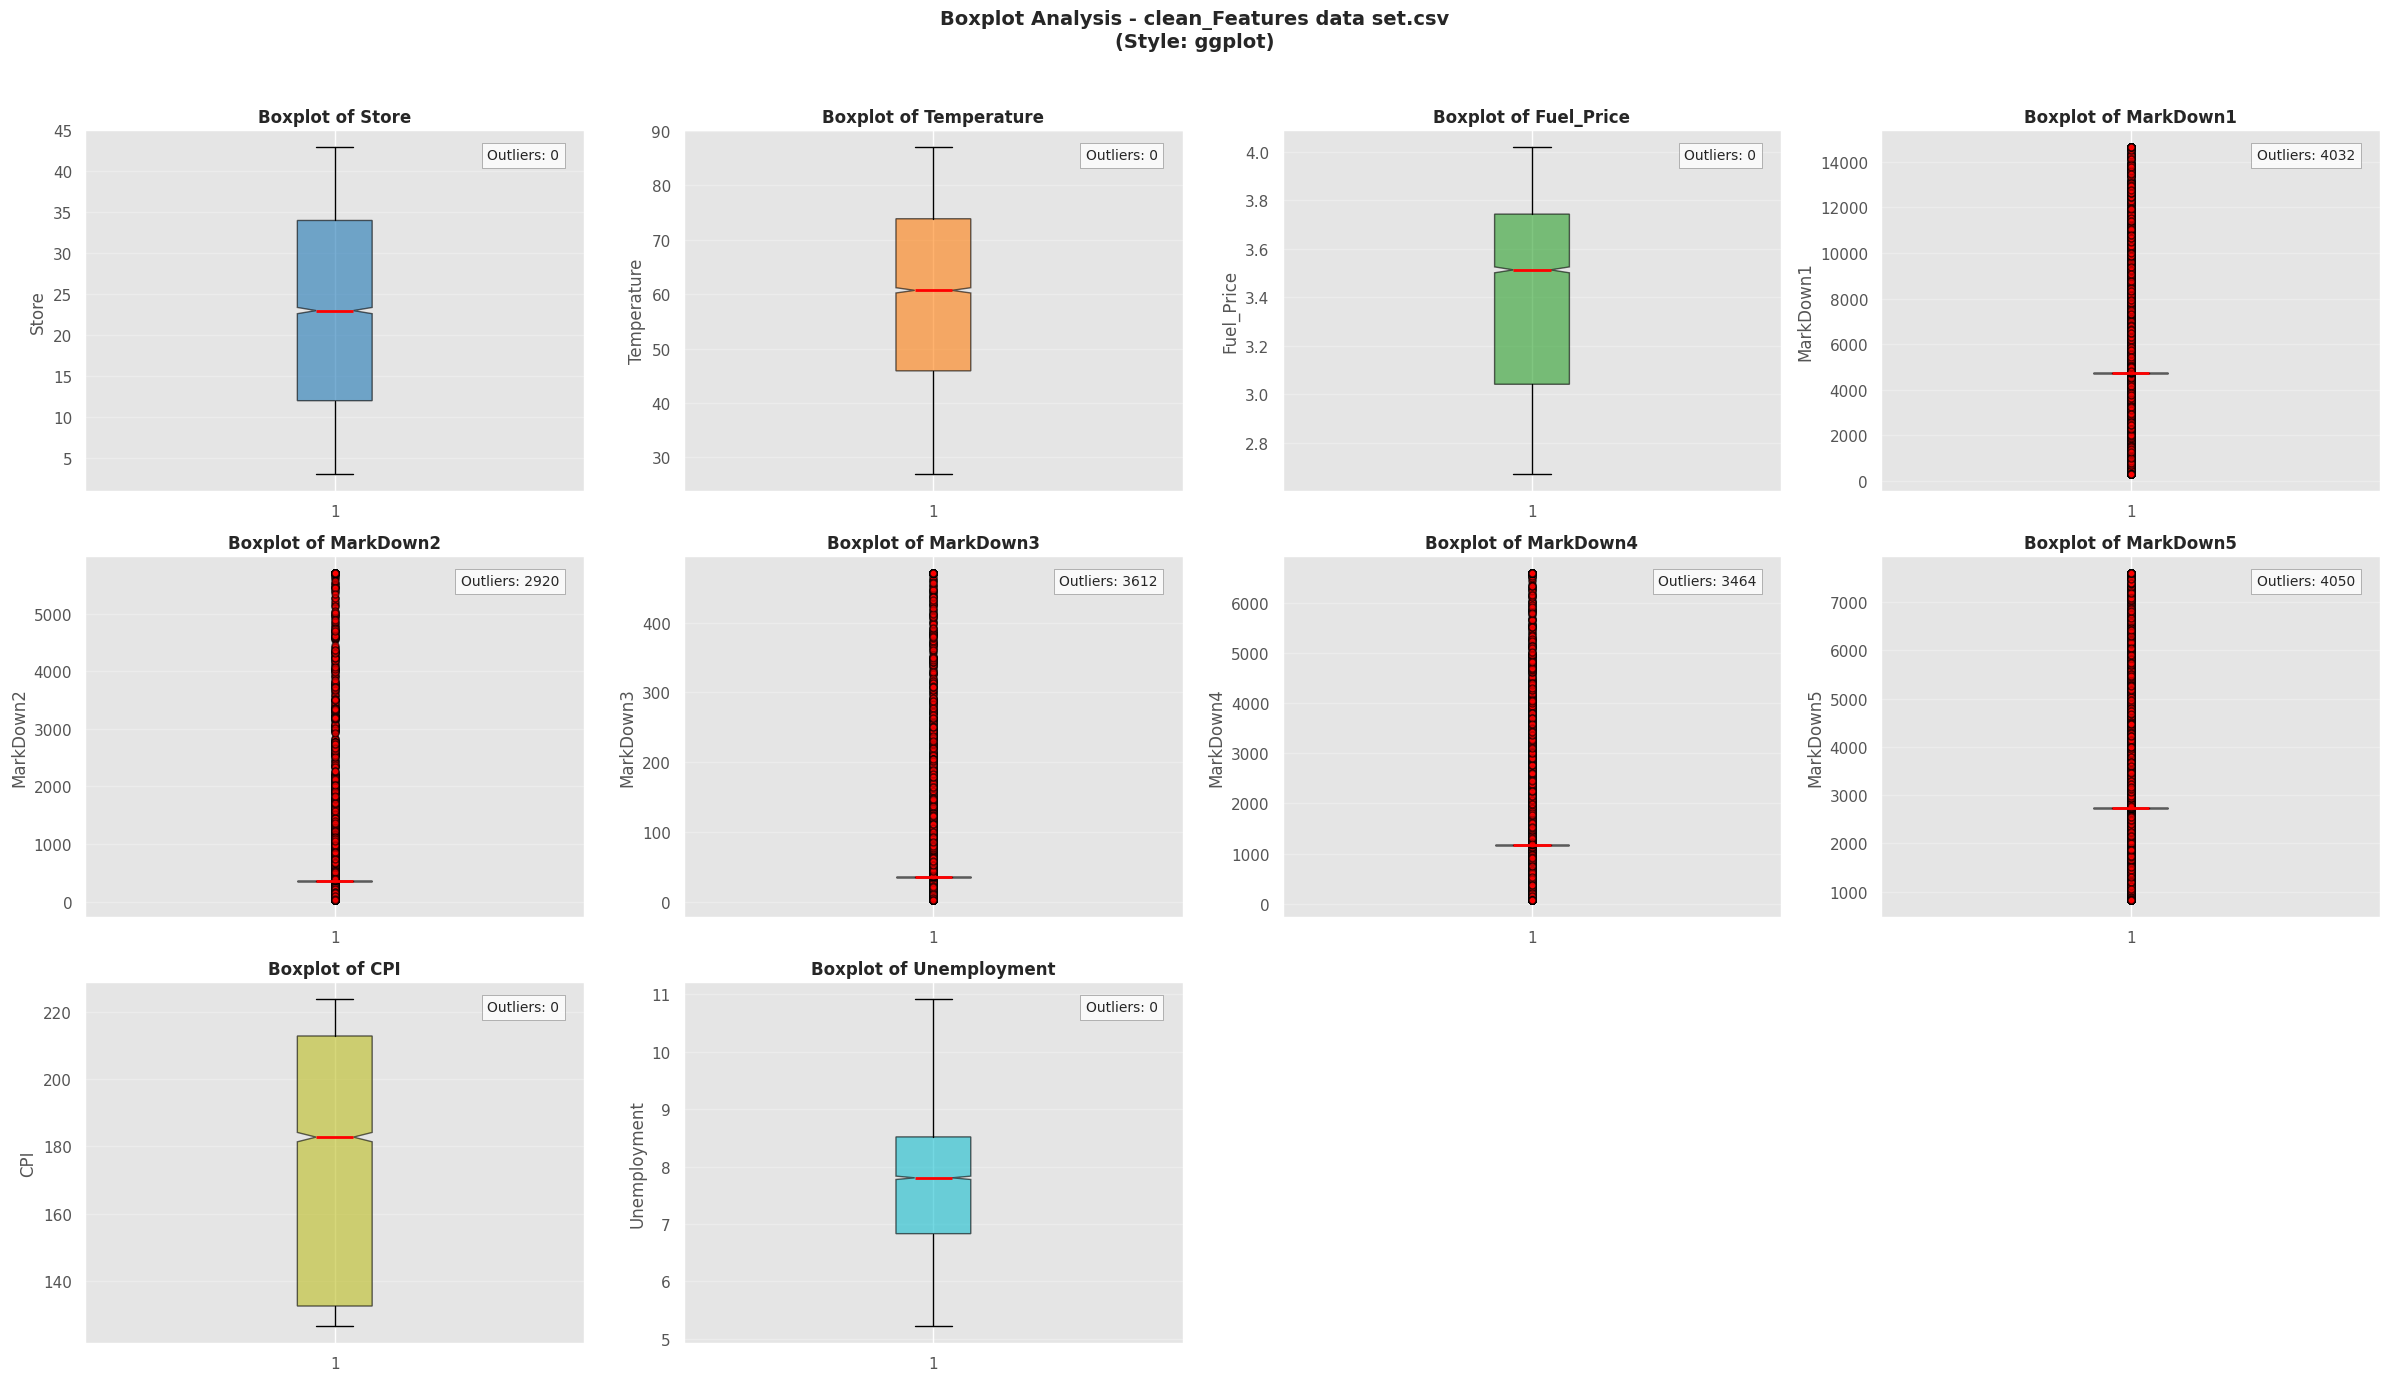

In [ ]:
def main_quality_analysis_with_plots():
    # Load existing analysis
    with open("datasets_analysis.json", "r", encoding="utf-8") as f:
        analysis = json.load(f)

    updated_analysis = {"files_analysis": {}}

    for dataset_name, dataset_info in analysis["files_analysis"].items():
        # Calculate global score
        scores = calculate_global_score(dataset_info)
        print(f"\nDataset: {dataset_name}")
        print("Quality Scores:", scores)

        dataset_path = DATASETS_FOLDER / dataset_name

        if scores["global_score"] < ALERT_THRESHOLD and dataset_path.exists():
            print(f"ALERT: {dataset_name} ({scores['global_score']:.2f}) below threshold.")
            # Clean dataset
            clean_path = clean_dataset(dataset_path)
            # Generate new metadata using your function
            new_dataset_info = extract_csv_metadata(clean_path)
            new_scores = calculate_global_score(new_dataset_info)
            print(f"New analysis after cleaning: {new_scores}")

            if new_scores["global_score"] >= ALERT_THRESHOLD:
                print("Cleaning improved the dataset and it is now above threshold.")
                # Plot histograms and boxplots for the cleaned dataset
                plot_histograms(new_dataset_info)
                plot_boxplots_with_outliers(new_dataset_info)
            else:
                print("Dataset remains below threshold after cleaning.")

            updated_analysis["files_analysis"][f"clean_{dataset_name}"] = new_dataset_info
        else:
            updated_analysis["files_analysis"][dataset_name] = dataset_info
            if scores["global_score"] >= ALERT_THRESHOLD:
                print("Dataset meets quality standards.")
                # Plot histograms and boxplots for datasets that already pass
                plot_histograms(dataset_info)
                plot_boxplots_with_outliers(dataset_info)
            else:
                print("CSV file not found for cleaning.")

    # Save updated analysis
    with open("datasets_analysis_clean.json", "w", encoding="utf-8") as f:
        json.dump(updated_analysis, f, ensure_ascii=False, indent=4)

    print("\nNew analysis saved at datasets_analysis_clean.json")

main_quality_analysis_with_plots()
